## Оценка пространственной сложности и энтропии строения астроцитов на разных стадиях развития нервной системы

 - [ ] Научиться загружать отдельные изображения
 - [ ] Выбрать подходящие данные (содержат одну клетку), желательно сравнивать между собой только клетки, окрашенные одним красителем
 - [ ] Научиться рассчитывать сложность/энтропию $(H,C)$ для Z-проекции стеков. Сравнить результаты для нефильтрованных и фильтрованных изображений
 - [ ] Научиться собирать статистику $(H,C)$, например, для всей клетки, либо в кольце на некотором расстоянии от тела клетки — чтобы потом можно было проводить сравнение между группами
 - [ ] Подобрать оптимальные параметры алгоритма рассчета $(H,C)$
 - [ ] Рассчитать суммарные параметры $(H,C)$ для групп клеток животных разного возраста, произвести статистический анализ
 - [ ] Сравнить результаты для "сырых" и "улучшенных" изображений.
 - [ ] Сделать выводы по полученным результатам

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
names = !ls *.pic

In [3]:
print(len(names))
#print (names)

91


In [4]:
from importlib import reload

In [5]:
import scent

Can't load imreg package, affine and homography registrations won't work


In [8]:
import ccdb

In [9]:
stack, meta = ccdb.read_pic(names[0])

In [10]:
stack.shape

(40, 1024, 1024)

In [13]:
projection = stack.max(0)

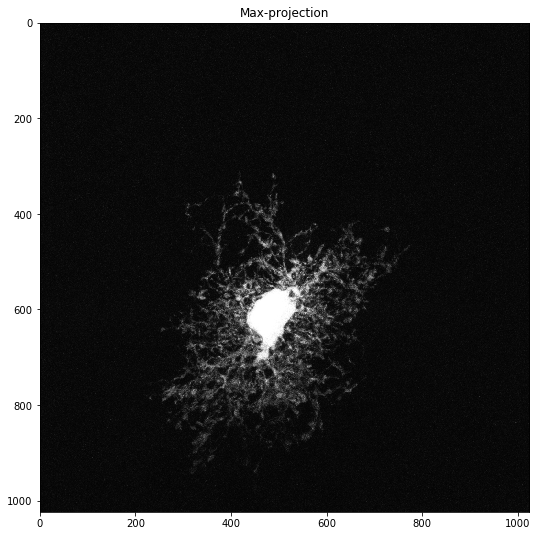

In [15]:
figure(figsize=(9,9)); 
imshow(projection,cmap='gray')
title("Max-projection")

Определим несколько вспомогательных функций, чтобы можно было отфильтровать/"улучшить" исходные изображения (каждая z-плоскость будет обрабатываться отдельно). Сначала делается фильтрация, оставляющая только детали изображения (high-pass filter), потом применяется coherence-enhancing diffusion фильтр. 

Мы должны сравнить результаты (сложность, энтропия) для необработанных и обработанных изображений.

In [16]:
from imfun.filt import dctsplines
from imfun.filt import cedf

from imfun import fseq, ui,core
from imfun import multiscale

from imfun.core.fnutils import flcompose

In [17]:
#high_pass_l1 = lambda f_,s1=1.5,s2=32.: dctsplines.l1spline(f_,s1)-dctsplines.l1spline(f_,s2)
high_pass_l1 = lambda f_,s1=1.5,s2=32.: dctsplines.l1spline(f_,s1)-dctsplines.l2spline(f_,s2)
high_pass_l2 = lambda f_, s1=0.5, s2=64.: dctsplines.l2spline(f_,s1)-dctsplines.l2spline(f_,s2)
high_pass_atrous = lambda f_: multiscale.atrous.detrend(f_,5)

In [18]:
pipeline_simple = flcompose(lambda f_: high_pass_l1(f_))

pipeline1 = flcompose(lambda f_: high_pass_l1(f_),
                      lambda ff_: cedf.coh_enh_diffusion(ff_, 0.5, T=50,verbose=False))

pipeline2 = flcompose(lambda f_: high_pass_l2(f_),
                      lambda ff_: cedf.coh_enh_diffusion(ff_, 0.5, T=10,verbose=False))

pipeline3 = flcompose(lambda f_: high_pass_atrous(f_),
                      lambda ff_: cedf.coh_enh_diffusion(ff_, 0.5, T=100,verbose=False))

In [22]:
from numba import jit

def simple_rescale(stack, p=99.95):
    px = percentile(stack[stack>0],p)
    return clip(stack/px, 0,1)

@jit
def make_meanproj(stack,p=25):
    nplanes,nrows,ncols = stack.shape
    #counts = np.zeros((nrows,ncols))
    out = np.zeros((nrows,ncols))
    #px = np.zeros((nrows,ncols))
    for row in range(nrows):
        for col in range(ncols):
            v = stack[:,row,col]
            px = percentile(v, p)
            mask = v > px
            if any(mask):
                out[row,col] = sum(v[mask])/sum(mask)
    return out

In [32]:
def make_filtered_proj(stack,pipeline=pipeline3):
    
    #stack,meta = ccdb.read_pic(data_path+name)
    #print (name, stack.shape)
    #print (ccdb.get_axes(meta))

    stack_r = simple_rescale(stack)

    maxproj = stack_r.max(0)
    meanproj = make_meanproj(stack_r)
    fstack = array([pipeline(f) for f in stack_r])
    uxp = fstack.max(0)
    ui.group_maps([meanproj, maxproj, uxp],3, 
                  titles=('meanp','maxp','filtered-maxp'),
                  figscale=3.5, samerange=0,);tight_layout()
    return maxproj, meanproj, uxp


CPU times: user 38min 46s, sys: 8.82 s, total: 38min 55s
Wall time: 39min 25s


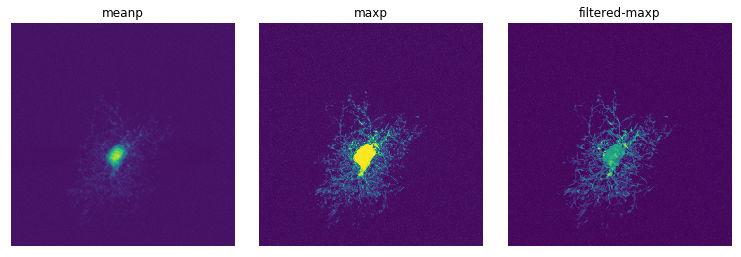

In [38]:
%time umaxp, umeanp, fmaxp = make_filtered_proj(stack)

**NB** фильтрация занимает какое-то время, поэтому будет разумно сохранять отфильтрованные проекции в отдельные файлы, чтобы их можно было загружать в следующий раз, а не прогонять фильтрацию снова. 

CPU times: user 1min 2s, sys: 6.33 s, total: 1min 8s
Wall time: 1min 19s


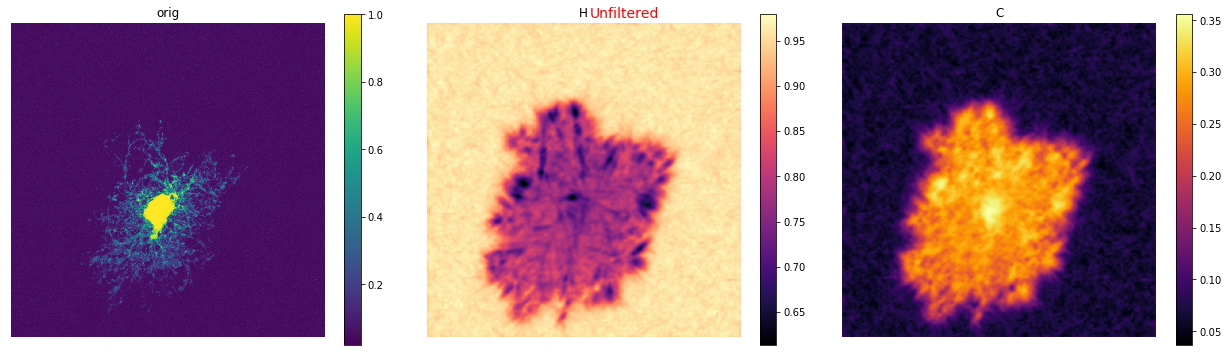

In [39]:
%time H,C = scent.calc_cecp(umaxp, startscale=4)
suptitle("Unfiltered",size=14,color='red')

In [ ]:
%time Hf,Cf = scent.calc_cecp(fmaxp, startscale=4)
suptitle('Filtered',size=14,color='red')